In [1]:
# Part 1 : gensim LDA based on NLTK & SpaCy

# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tharsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# For Shakespeare : We need to change this: kill thou, thy and shall & keep subject, re, edu and use
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(['from', 'thou', 'thy', 'shall', 'would'])  # make, come, go also very common


In [4]:
# Import Dataset -- Shakespeare

# Pull all into "data" = all Shakespeare raw text

# directory containing all source texts for training the model 
data_dir="/Users/tharsen/Desktop/populism-rcc-hackathon/corpus/"

import glob, os
os.chdir(data_dir)

#documents = list()
data = list()   # reset data to 0

for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read()
    print(filename + " = " + str(len(filedata)) + " chars")
    #documents = documents + filedata.split(".")
    data.append(filedata)


1H4_h.txt = 130423 chars
1H6_h.txt = 116317 chars
2H4_h.txt = 141574 chars
2H6_h.txt = 135863 chars
3H6_h.txt = 129551 chars
Ado_c.txt = 111116 chars
Ant_t.txt = 133668 chars
AWW_c.txt = 121896 chars
AYL_c.txt = 114429 chars
Cor_t.txt = 146443 chars
Cym_t.txt = 147159 chars
Err_c.txt = 76924 chars
H5_h.txt = 141819 chars
H8_h.txt = 128223 chars
Ham_t.txt = 163429 chars
JC_t.txt = 104561 chars
John_t.txt = 112414 chars
Lear_t.txt = 140510 chars
LLL_c.txt = 115391 chars
Lucrece_x.txt = 86177 chars
M4M_c.txt = 116348 chars
Mac_t.txt = 91625 chars
MerchV_c.txt = 112334 chars
MND_c.txt = 88608 chars
Oth_t.txt = 141395 chars
Pericles_x.txt = 97471 chars
PhxTur_x.txt = 2072 chars
R2_h.txt = 120934 chars
R3_h.txt = 156881 chars
Rom_t.txt = 130885 chars
Shr_c.txt = 111364 chars
Sonnets_x.txt = 97204 chars
TGV_c.txt = 91686 chars
Tim_t.txt = 98749 chars
Tit_t.txt = 109892 chars
Tmp_c.txt = 88800 chars
TN_c.txt = 104476 chars
TNK_x.txt = 127691 chars
Tro_c.txt = 142635 chars
VenusAdonis_x.txt = 5

In [5]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])
#print('\n')

CPU times: user 2.57 s, sys: 73.6 ms, total: 2.64 s
Wall time: 2.64 s


In [6]:
%%time

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])
#print('\n')

CPU times: user 14.2 s, sys: 108 ms, total: 14.4 s
Wall time: 14.4 s


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
%%time
# This cell takes 2-3 minutes to run on my machine.  -j

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])
#print('\n')

CPU times: user 57 s, sys: 11 s, total: 1min 8s
Wall time: 28.3 s


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [10]:
#id2word[0]

In [11]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [34]:
%%time

#
#  NB: this cell will likely run for several hours. You might want to run it on Midway and/or overnight.
#

# Set up loop
topics_min = 2  #for num_topics
topics_max = 20 #for num_topics
seed_breaks = 10  
seed_start = 10
seed_end = 200
scores = []

for tloop in range(topics_min,topics_max):
    for seedloop in range(seed_start,seed_end,seed_breaks):
        print('topics: ' + str(tloop))
        print('seed: ' + str(seedloop))
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=tloop,
                                                    random_state=seedloop,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        # Compute Perplexity
        print('perplexity: ', lda_model.log_perplexity(corpus))
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('coherence score: ', coherence_lda)
        print('\n')
        scores.append([tloop, seedloop, seed_breaks, lda_model.log_perplexity(corpus), coherence_lda])




topics: 2
seed: 10
perplexity:  -7.845495035110218
coherence score:  0.23710203111636


topics: 2
seed: 20
perplexity:  -7.856918971276514
coherence score:  0.25115444597659564


topics: 2
seed: 30
perplexity:  -7.849406501381914
coherence score:  0.246192466498652


topics: 2
seed: 40
perplexity:  -7.864128745370529
coherence score:  0.25126729261944125


topics: 2
seed: 50
perplexity:  -7.85420370390863
coherence score:  0.2514448336547609


topics: 2
seed: 60
perplexity:  -7.856607180025092
coherence score:  0.25126729261944125


topics: 2
seed: 70
perplexity:  -7.850865981337795
coherence score:  0.24769576577325564


topics: 2
seed: 80
perplexity:  -7.861751736107694
coherence score:  0.2560433688902949


topics: 2
seed: 90
perplexity:  -7.851006414785241
coherence score:  0.2407618265269432


topics: 2
seed: 100
perplexity:  -7.863178361624868
coherence score:  0.24584633288068722


topics: 2
seed: 110
perplexity:  -7.8488721622339215
coherence score:  0.24335119600541852


topic

topics: 6
seed: 150
perplexity:  -7.869496739632305
coherence score:  0.26446487781285133


topics: 6
seed: 160
perplexity:  -7.861734135391257
coherence score:  0.24770369892383307


topics: 6
seed: 170
perplexity:  -7.870836331871502
coherence score:  0.2498555129468826


topics: 6
seed: 180
perplexity:  -7.860199068558778
coherence score:  0.2497626187334909


topics: 6
seed: 190
perplexity:  -7.853892579778593
coherence score:  0.25347090292705526


topics: 7
seed: 10
perplexity:  -7.8711303628530365
coherence score:  0.2513127002347753


topics: 7
seed: 20
perplexity:  -7.862219227313595
coherence score:  0.24900924603345345


topics: 7
seed: 30
perplexity:  -7.860907665516646
coherence score:  0.2545688911755744


topics: 7
seed: 40
perplexity:  -7.865624502749276
coherence score:  0.2526531408449014


topics: 7
seed: 50
perplexity:  -7.866239703982568
coherence score:  0.30803871216322737


topics: 7
seed: 60
perplexity:  -7.865371895138403
coherence score:  0.24612670902295244


topics: 11
seed: 100
perplexity:  -7.888998961651951
coherence score:  0.29100739322028724


topics: 11
seed: 110
perplexity:  -7.882485664216814
coherence score:  0.26455987799639397


topics: 11
seed: 120
perplexity:  -7.893122123229278
coherence score:  0.25483970522158067


topics: 11
seed: 130
perplexity:  -7.878729870376336
coherence score:  0.25483198103204807


topics: 11
seed: 140
perplexity:  -7.879260224639721
coherence score:  0.26915141099384143


topics: 11
seed: 150
perplexity:  -7.879540952533368
coherence score:  0.2882438879661929


topics: 11
seed: 160
perplexity:  -7.899319345604497
coherence score:  0.25849908272963273


topics: 11
seed: 170
perplexity:  -7.902300056786724
coherence score:  0.25917539922417887


topics: 11
seed: 180
perplexity:  -7.875692270902875
coherence score:  0.2585249747446306


topics: 11
seed: 190
perplexity:  -7.884429519860867
coherence score:  0.26100557892922377


topics: 12
seed: 10
perplexity:  -7.893816294301457
coherence score:  0.

perplexity:  -7.919283461617713
coherence score:  0.2623733489103805


topics: 16
seed: 50
perplexity:  -7.935689904281891
coherence score:  0.29017239990701776


topics: 16
seed: 60
perplexity:  -7.946758655161481
coherence score:  0.28355581032991184


topics: 16
seed: 70
perplexity:  -7.936135318895877
coherence score:  0.2570333555814491


topics: 16
seed: 80
perplexity:  -7.929942113148179
coherence score:  0.25166820571981685


topics: 16
seed: 90
perplexity:  -7.968359187852261
coherence score:  0.2731570836694869


topics: 16
seed: 100
perplexity:  -7.91775748194653
coherence score:  0.2947574004953979


topics: 16
seed: 110
perplexity:  -7.9618455340054455
coherence score:  0.2472205603479688


topics: 16
seed: 120
perplexity:  -7.970228491214495
coherence score:  0.2571434927334234


topics: 16
seed: 130
perplexity:  -7.92349326241929
coherence score:  0.264828506862982


topics: 16
seed: 140
perplexity:  -7.961832544837201
coherence score:  0.28406867524509677


topics: 16
s

KeyboardInterrupt: 

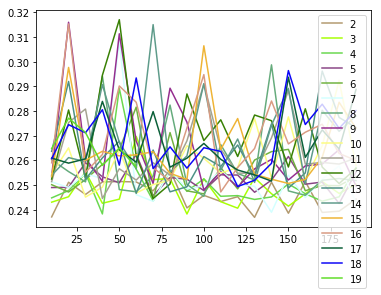

In [103]:
# Plot scores array
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib._color_data as mcd
import colorsys
from pprint import pprint

# plot coherences for each number of topics, varied by seed
# scores = lists of [topics, seed, perplexity, coherence]

# get XKCD colors, set as list()
mxl = list(mcd.XKCD_COLORS)

for tloop in range(topics_min, topics_max):    #(topics_min, topics_max):
    #print(tloop)
    vx = []
    vy = []
    for vals in scores:
        if vals[0] == tloop:
            vx.append(vals[1])
            vy.append(vals[4])
    plt.plot(vx, vy, color=(mxl[tloop]), label=str(tloop))
    plt.legend()


In [104]:
pprint(scores)

[[2, 10, 10, -7.845498358010974, 0.23710203111636],
 [2, 20, 10, -7.856918655235242, 0.25115444597659564],
 [2, 30, 10, -7.8494128962408025, 0.246192466498652],
 [2, 40, 10, -7.864135943912866, 0.25126729261944125],
 [2, 50, 10, -7.854197707704988, 0.2514448336547609],
 [2, 60, 10, -7.856611937962477, 0.25126729261944125],
 [2, 70, 10, -7.850866219854499, 0.24769576577325564],
 [2, 80, 10, -7.861752972267878, 0.2560433688902949],
 [2, 90, 10, -7.851001679047321, 0.2407618265269432],
 [2, 100, 10, -7.863175273313351, 0.24584633288068722],
 [2, 110, 10, -7.848865423732633, 0.24335119600541852],
 [2, 120, 10, -7.8466059569548, 0.24529126458538847],
 [2, 130, 10, -7.851447478267521, 0.2369269787003957],
 [2, 140, 10, -7.858231501527486, 0.25117795316646335],
 [2, 150, 10, -7.850753518316971, 0.2385960544905832],
 [2, 160, 10, -7.850931607065096, 0.2514448336547609],
 [2, 170, 10, -7.851016469668606, 0.23891698323243352],
 [2, 180, 10, -7.851062829907345, 0.2394237413548923],
 [2, 190, 10, 

In [14]:
%%time

# Visualize the topics
#
# If you get an error like this: "pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. 
# A future version of pandas will change to not sort by default."
#
# then from the command line do: "pip install pandas==0.21.0"

#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)  # sort=False ? sort=True
#vis
#print('\n')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [15]:
#vis